In [ ]:
using  Plots, Optim, Dates, DiffEqParamEstim, Flux, DiffEqFlux, OrdinaryDiffEq, MAT, Statistics, LinearAlgebra

In [2]:
GS_mean = [-101.42291847737759 20384.542004960465;
-69.45971918964945 21119.072350709095;
-50.34850444109978 33766.773366120455;
-40.36503932334175 36792.65681639921;
-15.4415308191833 35790.60055540246;
-0.2163667069439441 39585.56801560215;
0.6828058423250809 25036.991499374642;
1.5166161434153764 22449.706399847375;
2.46560532508002 28784.686155215913;
5.767635441177532 24513.174909376135;
15.093944982652516 27798.528819451807;
34.91354517767934 30811.693129544445]

GS_AMP_mean = [-101.32081204643899 1699.0651431963197;
-69.677357810612 946.9399868568944;
-50.33083896861906 533.9919021474198;
-40.333594782326045 1038.305810527214;
-15.411499515966057 294.87206664829864;
-0.005440965524059038 986.15733576411;
0.09454560871685658 12688.614249676728;
1.5734989648033206 12040.150085854206;
2.419321787180536 7254.573590825261;
4.681208883612783 13329.234943717805;
14.874539814441874 7949.674601996914;
34.905419060338204 2298.7726029720434]

PII = [-100.76322958187433 571.2230990278717;
-69.08256359498955 469.27525484344596;
-49.78293827241711 354.62037372054965;
-39.739310629416224 126.08657949112057;
-14.817909162403069 99.32241097299493;
0.20554929265804844 125.00112134106439;
1.0010734971787087 1354.327329922463;
1.9684768600057794 1145.6053896136905;
2.4428489837659697 956.4620642842406;
5.616333902476242 1295.5062630636235;
14.866231486659046 1353.9505593249226;
34.999775731787196 1317.5338869269572]


PII_UMP = [-100.56515589631033 871.2177165907642;
-68.9921386515799 1291.0119280786794;
-49.67277772627915 1355.7043367491874;
-39.759763890425546 1440.2175700688654;
-14.775567323822372 1984.1038690752075;
0.15351906728346876 1152.1764482493622;
0.3939345914281489 1836.952523914467;
1.0868336617616592 633.6728255701644;
2.0628489239610985 503.21152080760476;
5.36622999153758 522.6869724090293;
15.134276854623351 789.8128407007932;
34.961381013752145 968.6218867834257];

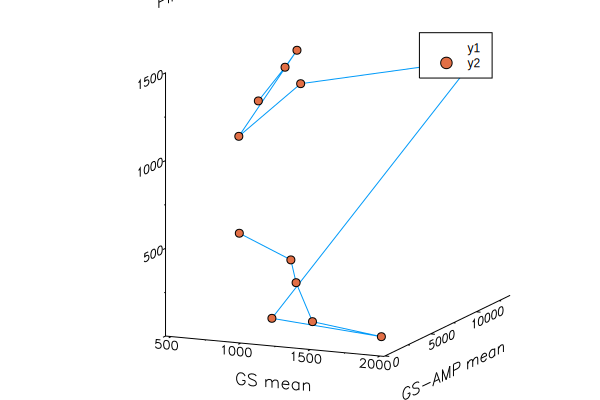

In [5]:
a = GS_mean[:,2]
b = GS_AMP_mean[:,2]
c = PII[:,2]
d = PII_UMP[:,2]
plt=plot(d,b,c, xlab = "GS mean", ylab = "GS-AMP mean", zlab  = "PII", grid = "off")
scatter!(d,b,c)

In [7]:
# Observed data
ode_data = transpose(hcat(a, b, c, d))
u0 = [a[1], b[1], c[1], d[1]]
tspan = (0.,1.)
t = GS_mean[:,1].+abs(GS_mean[1])
t = t./t[end]
species1 = "GS"
species2 = "GS-AMP"
species3 = "PII"
species4 = "PII-UMP"
t

12-element Array{Float64,1}:
 0.0                
 0.2344435115215971 
 0.37462035223020385
 0.44784702138466465
 0.6306558447616379 
 0.7423293010334711 
 0.7489245472732738 
 0.7550403748276683 
 0.7620010158493223 
 0.7862207295456666 
 0.8546272973225113 
 1.0                

In [8]:
mutable struct saver
    losses::Array{Float64,1}
    l2s::Array{Float64,1}
    times::Array{Dates.Time,1}
    count_epochs::Int128
end
function saver(n_epochs)
    losses = zeros(n_epochs)
    l2s = zeros(n_epochs)
    times = fill(Dates.Time(Dates.now()), n_epochs)
    count_epochs = 0
    return saver(losses, l2s, times, count_epochs)
end
function update_saver(saver, loss_i, l2_i, time_i)
    epoch_i = saver.count_epochs
    saver.losses[epoch_i] = loss_i
    saver.l2s[epoch_i] = l2_i
    saver.times[epoch_i] = time_i
end

update_saver (generic function with 1 method)

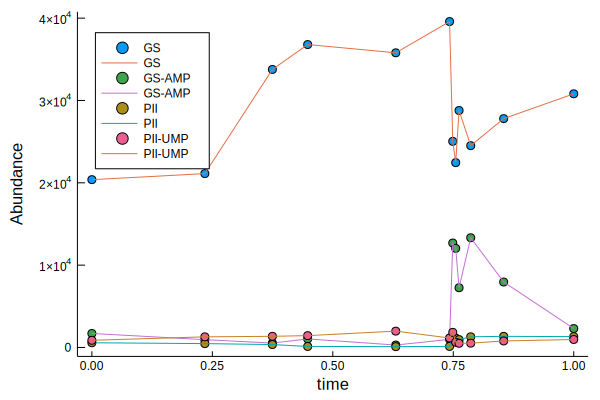

In [9]:

scatter(t, ode_data[1,:], grid = "off", xlab = "time", ylab = "Abundance", label = species1, legend =:topleft)
plot!(t, ode_data[1,:], label = species1)

scatter!(t, ode_data[2,:], grid = "off", xlab = "time", ylab = "Abundance", label = "GS-AMP ")
plot!(t, ode_data[2,:], grid = "off", xlab = "time", ylab = "Abundance", label = "GS-AMP ")

scatter!(t, ode_data[3,:], grid = "off", xlab = "time", ylab = "Abundance", label = "PII ")
plot!(t, ode_data[3,:], grid = "off", xlab = "time", ylab = "Abundance", label = "PII ")

scatter!(t, ode_data[4,:], grid = "off", xlab = "time", ylab = "Abundance", label = "PII-UMP ")
plot!(t, ode_data[4,:], grid = "off", xlab = "time", ylab = "Abundance", label = "PII-UMP ")

In [ ]:

u0 = Float32[2.; 0.]
tspan = (0.,1.5)
function trueODEfunc(du, u, p, t)
  true_A = [-0.1 2.0; -2.0 -0.1]
  du .= ((u.^3)'true_A)'
end
prob = ODEProblem(trueODEfunc, u0, tspan)
ode_data = solve(prob,Tsit5(),saveat=t)
scatter(ode_data)

In [ ]:
print(t)

In [21]:
# Building a neural ODE 
# Derivative is modeled by a neural net. Chain concatinates the functions ode function and two dense layers.
dudt = Chain(Dense(4,100,tanh),
       Dense(100,100,tanh),
       Dense(100,100,tanh),
       Dense(100,4))
# Parameters of the model which are to be learnt. They are: W1 (2x50), b1 (50), W2 (50x2), b2 (2)
ps = Flux.params(dudt)
# Getting loss function from two stage collocation function
function node_two_stage_function(model, x, tspan, saveat, ode_data,
            args...; kwargs...)
  dudt_(du,u,p,t) = du .= model(u)
  prob_fly = ODEProblem(dudt_,x,tspan)
  two_stage_method(prob_fly, saveat, ode_data)
end
# Rosenbrock23, TRBDF2, ABDF2, Rodas5, Rodas4P, Kvaerno5, KenCarp4, CVODE_BDF (not defined)
loss_n_ode = node_two_stage_function(dudt, u0, tspan, t, ode_data, Rosenbrock23(autodiff=false), reltol=1e-7, abstol=1e-9)
#  loss function
two_stage_loss_fct()=loss_n_ode.cost_function(ps)
# Defining anonymous function for the neural ODE with the model. in: u0, out: solution with current params.
n_ode = x->neural_ode(dudt, x, tspan, Rosenbrock23(autodiff=false), saveat=t, reltol=1e-7, abstol=1e-9)
n_epochs = 100000
verify = 1000 # for <verify>th epoch the L2 is calculated  
data1 = Iterators.repeated((), n_epochs)
opt1 = ADAM(0.0001)
sa = saver(n_epochs)
L2_loss_fct() = sum(abs2,ode_data .- n_ode(u0))
# Callback function to observe two stage training.
cb1 = function ()
    sa.count_epochs = sa.count_epochs +  1
    if mod(sa.count_epochs-1, verify)==0
        update_saver(sa, Tracker.data(two_stage_loss_fct()),Tracker.data(L2_loss_fct()), Dates.Time(Dates.now()))
        # println("\"",Tracker.data(two_stage_loss_fct()),"\" \"",Dates.Time(Dates.now()),"\";")
    else
        update_saver(sa, Tracker.data(two_stage_loss_fct()),0,Dates.Time(Dates.now()))
        # println("\"",Tracker.data(two_stage_loss_fct()),"\" \"",Dates.Time(Dates.now()),"\";")
    end
end

#19 (generic function with 1 method)

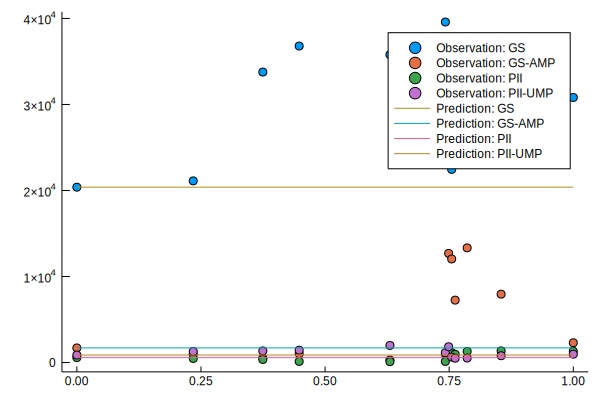

In [22]:
pred = n_ode(u0)
scatter(t, ode_data[1,:], label = string("Observation: ", species1), grid = "off")
scatter!(t, ode_data[2,:], label = string("Observation: ", species2))
scatter!(t, ode_data[3,:], label = string("Observation: ", species3))
scatter!(t, ode_data[4,:], label = string("Observation: ", species4))
plot!(t, Flux.data(pred[1,:]), label = string("Prediction: ", species1))
plot!(t, Flux.data(pred[2,:]), label = string("Prediction: ", species2))
plot!(t, Flux.data(pred[3,:]), label = string("Prediction: ", species3))
plot!(t, Flux.data(pred[4,:]), label = string("Prediction: ", species4))

In [ ]:
# train n_ode with collocation method
@time Flux.train!(two_stage_loss_fct, ps, data1, opt1, cb = cb1)

In [ ]:
pred = n_ode(u0)
scatter(t, ode_data[1,:], label = string("Observation: ", species1), grid = "off")
scatter!(t, ode_data[2,:], label = string("Observation: ", species2))
scatter!(t, ode_data[3,:], label = string("Observation: ", species3))
scatter!(t, ode_data[4,:], label = string("Observation: ", species4))
plot!(t, Flux.data(pred[1,:]), label = string("Prediction: ", species1))
plot!(t, Flux.data(pred[2,:]), label = string("Prediction: ", species2))
plot!(t, Flux.data(pred[3,:]), label = string("Prediction: ", species3))
plot!(t, Flux.data(pred[4,:]), label = string("Prediction: ", species4))

In [ ]:
header = string("Collocation model")
scatter(range(1, stop = length(sa.l2s)), log.(sa.l2s), width  = 2, label = "L2 control", grid = "off")
plot!(range(1, stop = length(sa.losses)), log.(sa.losses), width  = 2, label = header)
# 5% of time even with l2s

In [ ]:
opt1 = ADAM(0.000001)
sa = saver(n_epochs)
# train n_ode with collocation method
@time Flux.train!(two_stage_loss_fct, ps, data1, opt1, cb = cb1)

In [ ]:
pred = n_ode(u0)
scatter(t, ode_data[1,:], label = string("Observation: ", species1), grid = "off")
scatter!(t, ode_data[2,:], label = string("Observation: ", species2))
plot!(t, Flux.data(pred[1,:]), label = string("Prediction: ", species1))
plot!(t, Flux.data(pred[2,:]), label = string("Prediction: ", species2))

In [ ]:
header = string("Collocation model")
scatter(range(1, stop = length(sa.l2s)), log.(sa.l2s), width  = 2, label = "L2 control", grid = "off")
plot!(range(1, stop = length(sa.losses)), log.(sa.losses), width  = 2, label = header)
# 5% of time even with l2s